# GRAPE calculation of control fields for cnot implementation

Robert Johansson (robert@riken.jp)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import time
import numpy as np

In [2]:
from qutip import *
from qutip.control import *

In [3]:
T = 2 * np.pi 
times = np.linspace(0, T, 500)

In [4]:
U = cnot()
R = 500
H_ops = [tensor(sigmax(), identity(2)),
         tensor(sigmay(), identity(2)),
         tensor(sigmaz(), identity(2)),
         tensor(identity(2), sigmax()),
         tensor(identity(2), sigmay()),
         tensor(identity(2), sigmaz()),
         tensor(sigmax(), sigmax()) +
         tensor(sigmay(), sigmay()) +
         tensor(sigmaz(), sigmaz())]

H_labels = [r'$u_{1x}$', r'$u_{1y}$', r'$u_{1z}$',
            r'$u_{2x}$', r'$u_{1y}$', r'$u_{2z}$',
            r'$u_{xx}$',
            r'$u_{yy}$',
            r'$u_{zz}$',
        ]

In [5]:
H0 = 0 * np.pi * (tensor(sigmax(), identity(2)) + tensor(identity(2), sigmax()))

c_ops = []

# This is the analytical result in the absense of single-qubit tunnelling
#g = pi/(4 * T)
#H = g * (tensor(sigmax(), sigmax()) + tensor(sigmay(), sigmay()))

# GRAPE

In [6]:
from qutip.control.grape import plot_grape_control_fields, _overlap, grape_unitary_adaptive, cy_grape_unitary

In [7]:
from scipy.interpolate import interp1d
from qutip.ui.progressbar import TextProgressBar

In [8]:
u0 = np.array([np.random.rand(len(times)) * 2 * np.pi * 0.05 for _ in range(len(H_ops))])

u0 = [np.convolve(np.ones(10)/10, u0[idx,:], mode='same') for idx in range(len(H_ops))]

u_limits = None #[0, 1 * 2 * pi]
alpha = None

In [9]:
result = cy_grape_unitary(U, H0, H_ops, R, times, u_start=u0, u_limits=u_limits,
                          eps=2*np.pi*1, alpha=alpha, phase_sensitive=False,
                          progress_bar=TextProgressBar())

10.0%. Run time: 366.95s. Est. time left: 00:00:55:02
20.0%. Run time: 735.78s. Est. time left: 00:00:49:03
30.0%. Run time: 1103.50s. Est. time left: 00:00:42:54
40.0%. Run time: 1483.28s. Est. time left: 00:00:37:04
50.0%. Run time: 1849.76s. Est. time left: 00:00:30:49
60.0%. Run time: 2216.15s. Est. time left: 00:00:24:37
70.0%. Run time: 2578.35s. Est. time left: 00:00:18:25
80.0%. Run time: 2950.03s. Est. time left: 00:00:12:17
90.0%. Run time: 3321.43s. Est. time left: 00:00:06:09
Total run time: 3678.78s


## Plot control fields for cnot gate in the presense of single-qubit tunnelling

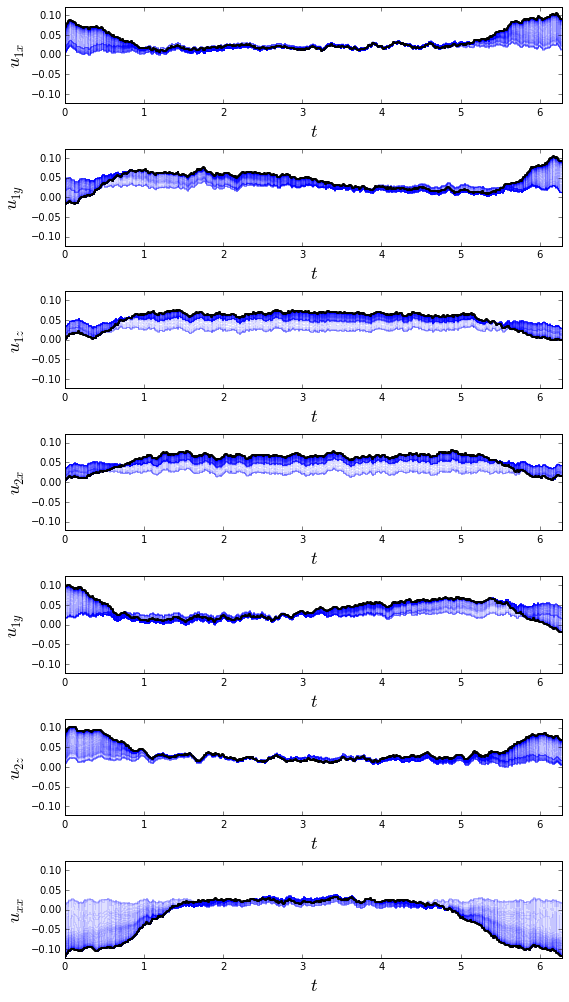

In [10]:
plot_grape_control_fields(times, result.u / (2 * np.pi), H_labels, uniform_axes=True);

## Fidelity/overlap

In [11]:
U

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = True
Qobj data =
[[ 1.  0.  0.  0.]
 [ 0.  1.  0.  0.]
 [ 0.  0.  0.  1.]
 [ 0.  0.  1.  0.]]

In [12]:
result.U_f

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = False
Qobj data =
[[  7.07106781e-01 +7.07106781e-01j   4.48226131e-10 +4.64693256e-10j
    1.32566550e-09 +1.65129110e-09j   1.64975974e-09 +1.32293207e-09j]
 [ -4.64692598e-10 -4.48223316e-10j   7.07106781e-01 +7.07106781e-01j
   -9.12552186e-10 -1.24159551e-09j  -1.26232308e-09 -8.96730565e-10j]
 [ -1.32293168e-09 -1.64975902e-09j   8.96730153e-10 +1.26232267e-09j
    1.74906986e-11 +4.31236308e-12j   7.07106781e-01 +7.07106782e-01j]
 [ -1.65129131e-09 -1.32566325e-09j   1.24159331e-09 +9.12553063e-10j
    7.07106781e-01 +7.07106781e-01j  -4.31000195e-12 -1.74898204e-11j]]

In [13]:
result.U_f/result.U_f[0,0]

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = False
Qobj data =
[[  1.00000000e+00 +0.00000000e+00j   6.45531489e-10 +1.16440158e-11j
    2.10502620e-09 +2.30252068e-10j   2.10201053e-09 -2.31102060e-10j]
 [ -6.45529034e-10 +1.16455406e-11j   1.00000000e+00 +3.00883207e-11j
   -1.52321244e-09 -2.32668764e-10j  -1.52668147e-09 +2.58512945e-10j]
 [ -2.10200976e-09 -2.31101827e-10j   1.52668089e-09 +2.58512951e-10j
    1.54170927e-11 -9.31849039e-12j   1.00000000e+00 +4.60255167e-10j]
 [ -2.10502476e-09 +2.30253808e-10j   1.52321151e-09 -2.32666590e-10j
    1.00000000e+00 -4.24428603e-10j  -1.54148022e-11 -9.31953897e-12j]]

In [14]:
_overlap(U, result.U_f).real, abs(_overlap(U, result.U_f)) ** 2

(0.7071067811865461, 0.9999999999999973)

## Test numerical integration of GRAPE pulse

In [15]:
U_f_numerical = propagator(result.H_t, times[-1], [], options=Odeoptions(nsteps=5000), args={})
U_f_numerical

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = False
Qobj data =
[[ 0.78340465-0.23277383j  0.53190530+0.11348496j -0.00151631-0.15246319j
  -0.01771949+0.11282889j]
 [-0.07344838+0.13495958j  0.06689834-0.32158322j  0.64490996-0.66191833j
   0.09429996-0.07458329j]
 [-0.18151322+0.49289232j  0.58152423-0.34218062j -0.34090290+0.06551709j
   0.38438101+0.02431454j]
 [-0.11414260-0.13987968j  0.22524875+0.30051913j -0.01974518-0.04255339j
   0.09904837-0.90241341j]]

In [16]:
U_f_numerical / U_f_numerical[0,0]

Quantum object: dims = [[2, 2], [2, 2]], shape = [4, 4], type = oper, isherm = False
Qobj data =
[[ 1.00000000+0.j          0.58433442+0.31848512j  0.05135682-0.17935644j
  -0.06010593+0.12616444j]
 [-0.13318460+0.13269986j  0.19054259-0.35387828j  0.98711830-0.55162173j
   0.13660006-0.05461592j]
 [-0.38468070+0.51486639j  0.80133893-0.19868389j -0.42268728-0.04196229j
   0.44237642+0.16248077j]
 [-0.08513095-0.2038486j   0.15946532+0.43098862j -0.00832924-0.05679341j
   0.43067882-1.02394421j]]

In [17]:
_overlap(result.U_f, U_f_numerical).real, abs(_overlap(result.U_f, U_f_numerical))**2

(0.11355125771393167, 0.1127464011373238)

# Process tomography

## Ideal cnot gate

In [18]:
op_basis = [[qeye(2), sigmax(), sigmay(), sigmaz()]] * 2
op_label = [["i", "x", "y", "z"]] * 2

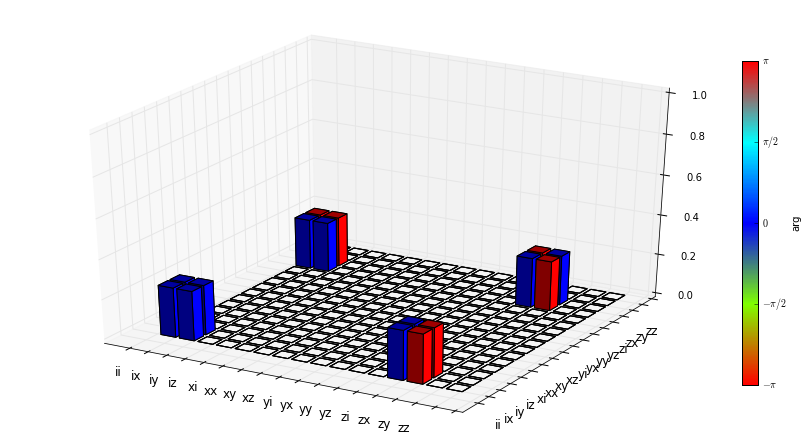

In [19]:
fig = plt.figure(figsize=(12,6))

U_i_s = to_super(U)

chi = qpt(U_i_s, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)

## cnot gate calculated using GRAPE

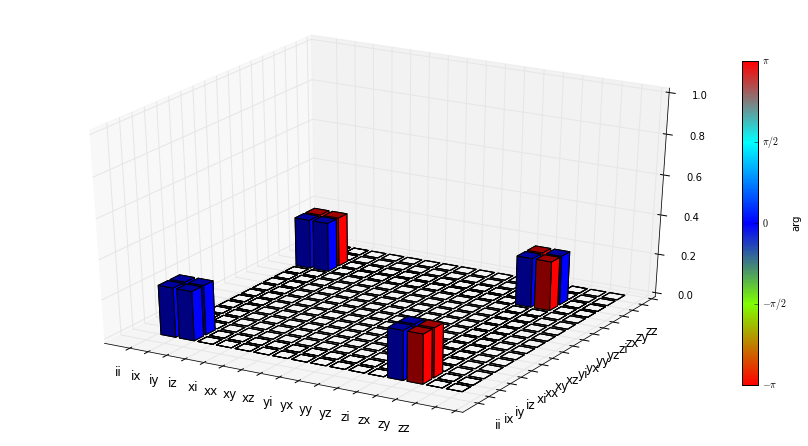

In [20]:
fig = plt.figure(figsize=(12,6))

U_f_s = to_super(result.U_f)

chi = qpt(U_f_s, op_basis)

fig = qpt_plot_combined(chi, op_label, fig=fig, threshold=0.001)

## Versions

In [21]:
from qutip.ipynbtools import version_table

version_table()